### Approche différente

Suite aux déconvenues précédement évoquées, une tentative d'utiliser le jeu de donnée sur la colonne 'match', qui semble etre la cible la plus évidente, j'ai tenté de ré-entrainer des modèles sur ce label.

Malheureusement le déséquilibre en terme de quantité de match/non-match (~6 pour 1) rend la prediction peu utile car même avec un score de prédiction élevé, la precision et le recall sont mauvais et le f1-score le confirme pour la détection de match. Par contre le modèle est excellent pour prédire quand les profils ne matchent pas...

---

In [4]:
%pip install pandas numpy matplotlib seaborn scipy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from scipy.io.arff import MetaData, loadarff
from pandas import DataFrame, Series
from numpy import ndarray
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
import sys

EPSILON: float = sys.float_info.epsilon
NL='\n'
TAB='\t'

# Récupération et traitement des données (cf. EDA)

In [6]:
# Chargement du jeu de données
data: ndarray
meta: MetaData
data, meta = loadarff('speeddating.arff')

original_df: DataFrame = DataFrame(data)
# Conversion des types des colonnes
for col in original_df.select_dtypes([object]):
    try:
        original_df[col] = original_df[col].astype(int)
    except:
        try:
            original_df[col] = original_df[col].astype(float)
        except:
            original_df[col] = original_df[col].astype(str)

# Correction des noms de colonnes
original_df.rename(
    columns={
        'sinsere_o': 'sincere_o',
        'intellicence_important': 'intelligence_important',
        'ambition': 'ambitious',
        'ambtition_important': 'ambitious_important',
        'ambition_partner': 'ambitious_partner',
        'ambitous_o': 'ambitious_o'
    },
    inplace=True
)

# Récupération des colonnes utiles
columns: list[str] = ['age', 'age_o', 'ambitious', 'ambitious_important', 'ambitious_o', 'ambitious_partner',
                      'art', 'attractive', 'attractive_important', 'attractive_o', 'attractive_partner',
                      'clubbing', 'concerts', 'd_age', 'decision', 'decision_o', 'dining', 'exercise',
                      'expected_happy_with_sd_people', 'expected_num_matches', 'funny', 'funny_important',
                      'funny_o', 'funny_partner', 'gaming', 'gender', 'guess_prob_liked', 'hiking',
                      'importance_same_race', 'importance_same_religion', 'intelligence', 'intelligence_important',
                      'intelligence_o', 'intelligence_partner', 'interests_correlate', 'like', 'match',
                      'met', 'movies', 'music', 'pref_o_ambitious', 'pref_o_attractive', 'pref_o_funny',
                      'pref_o_intelligence', 'pref_o_shared_interests', 'pref_o_sincere', 'race', 'race_o',
                      'reading', 'samerace', 'shared_interests_important', 'shared_interests_o',
                      'shared_interests_partner', 'shopping', 'sincere', 'sincere_important', 'sincere_o',
                      'sincere_partner', 'sports', 'theater', 'tv', 'tvsports', 'yoga' ]
df: DataFrame = original_df[columns].copy()

# Remplacement des catégories '?' par 'Other'
df.loc[df['race'] == '?', 'race'] = 'Other'
df.loc[df['race_o'] == '?', 'race_o'] = 'Other'

# Bornage des valeurs a 10 dans les activités 'gaming' et 'reading'
df.loc[df['gaming'] > 10, 'gaming'] = 10
df.loc[df['reading'] > 10, 'reading'] = 10

# Correction des valeurs d'ages
df.loc[df['age_o'].isna() & df['age'].notna(), 'd_age'] = float('nan')
df.loc[df['age_o'].notna() & df['age'].isna(), 'd_age'] = float('nan')
df.loc[df['age_o'].isna() & df['age'].isna(), 'd_age'] = float('nan')

mean_d_age: float = df['d_age'].describe()['mean']
df.loc[df['d_age'].isna(), 'd_age'] = mean_d_age

df.loc[df['age_o'].isna() & df['age'].notna(), 'age_o'] = df['age'] + df['d_age']
df.loc[df['age_o'].notna() & df['age'].isna(), 'age'] = df['age_o'] + df['d_age']
df.loc[df['age_o'].isna() & df['age'].isna(), ['age', 'age_o']] = [df['age'].describe()['mean'], df['age'].describe()['mean'] + mean_d_age]

# df = pd.concat([df.loc[df['match'] == 1], df.loc[df['match'] == 0].sample(frac=.5)])
# df.sort_index(inplace=True)

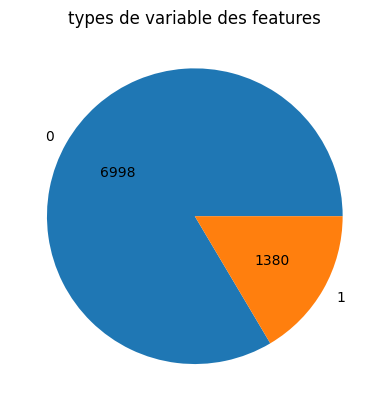

In [7]:
df_match_counts: Series = df['match'].value_counts()
plt.title("types de variable des features")
plt.pie(
    df_match_counts,
    labels=df_match_counts.index.tolist(),
    autopct=lambda pct: f"{pct * len(df[['match']]) / 100:.0f}",
)
plt.show()

# Imputation des données (cf. ml_impute)

In [8]:
transformer = ColumnTransformer(
    transformers=[
		('race', SimpleImputer(strategy='constant', fill_value='Other'), ['race', 'race_o']),
		('hobbies', SimpleImputer(strategy='constant', fill_value=0), ['art', 'clubbing', 'concerts', 'dining', 'exercise', 'gaming', 'hiking', 'movies', 'music', 'reading', 'shopping', 'sports', 'theater', 'tv', 'tvsports', 'yoga']),
		('met', SimpleImputer(strategy='most_frequent'), ['met']),
		('criterion', SimpleImputer(strategy='mean'), ['sincere', 'sincere_partner', 'sincere_o', 'pref_o_sincere', 'sincere_important', 'funny', 'funny_partner', 'funny_o', 'pref_o_funny', 'funny_important', 'attractive', 'attractive_partner', 'attractive_o', 'pref_o_attractive', 'attractive_important', 'ambitious', 'ambitious_partner', 'ambitious_o', 'pref_o_ambitious', 'ambitious_important', 'intelligence', 'intelligence_partner', 'intelligence_o', 'pref_o_intelligence', 'intelligence_important', 'shared_interests_partner', 'shared_interests_o', 'pref_o_shared_interests', 'shared_interests_important']),
		('importance_race_religion', SimpleImputer(strategy='mean'), ['importance_same_race', 'importance_same_religion']),
		('remains', SimpleImputer(strategy='mean'), ['expected_happy_with_sd_people', 'expected_num_matches', 'guess_prob_liked', 'like', 'interests_correlate']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [9]:
encoders = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(sparse_output=False, drop="if_binary"), [ 'race', 'race_o', 'gender']) # type: ignore
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

# Entrainement des modèles

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

def plots(model, X_test: DataFrame, y_test: Series):
    # Assure que le model passé en paramètre est compativle avec la méthode predict_proba
    if not hasattr(model, 'predict_proba'):
        raise ValueError("'model' must have predict_proba method")
    
    # Assure que le model passé en paramètre est compativle avec la méthode predict
    if not hasattr(model, 'predict'):
        raise ValueError("'model' must have predict method")
    
    # Réalisation des prédictions
    y_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)

    # Affichage du raport
    print(classification_report(y_test, y_pred))
    
    # Affichage de la patrice de confusion
    fig: Figure
    ax_cm: Axes
    ax_roc: Axes
    ax_01: Axes
    ax_1: Axes

    fig, ((ax_cm, ax_roc), (ax_01, ax_1)) = plt.subplots(2,2, figsize=(10,10))
    fig.suptitle(model.__repr__())

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(ax=ax_cm)

    # Recherche des TP/FP/TN/FN en fonction du seuil
    real_pred_df: DataFrame = DataFrame(
        columns=[
            'thresold',
            'TP0',
            'FP0',
            'TN0',
            'FN0',
            'TP1',
            'FP1',
            'TN1',
            'FN1'
        ]
    )

    for i in range(100+1):
        ratio = i/100
        real_pred_df.loc[i] = [
            ratio,
            ((y_test == 0) & (y_test_proba[:,0] > ratio)).sum(),
            ((y_test == 1) & (y_test_proba[:,0] > ratio)).sum(),
            ((y_test == 1) & (y_test_proba[:,0] <= ratio)).sum(),
            ((y_test == 0) & (y_test_proba[:,0] <= ratio)).sum(),
            ((y_test == 1) & (y_test_proba[:,1] > ratio)).sum(),
            ((y_test == 0) & (y_test_proba[:,1] > ratio)).sum(),
            ((y_test == 0) & (y_test_proba[:,1] <= ratio)).sum(),
            ((y_test == 1) & (y_test_proba[:,1] <= ratio)).sum(),
        ]

    score_df: DataFrame = DataFrame()
    score_df['recall 0'] = real_pred_df['TP0'] / (real_pred_df['TP0'] + real_pred_df['FN0'])
    score_df['precision 0'] = real_pred_df['TP0'] / (real_pred_df['TP0'] + real_pred_df['FP0'])
    score_df['accuracy 0'] = real_pred_df[['TP0', 'TN0']].sum(axis=1) / len(y_test)
    score_df['recall 1'] = real_pred_df['TP1'] / (real_pred_df['TP1'] + real_pred_df['FN1'])
    score_df['precision 1'] = real_pred_df['TP1'] / (real_pred_df['TP1'] + real_pred_df['FP1'])
    score_df['accuracy 1'] = real_pred_df[['TP1', 'TN1']].sum(axis=1) / len(y_test)
    
    score_df.plot.line(color=['orange', 'brown', 'red', 'cyan', 'lime', 'blue'], ax=ax_01)
    score_df[['recall 1', 'precision 1', 'accuracy 1']].plot.line(color=['cyan', 'lime', 'blue'], ax=ax_1)
    ax_01.set_xlabel('seuil %')
    ax_01.set_ylabel('score [0-1]')
    ax_1.set_xlabel('seuil %')
    ax_1.set_ylabel('score [0-1]')
    ax_01.axvline(x=50, color='green', linestyle='--')
    ax_1.axvline(x=50, color='green', linestyle='--')
    for y in range(1,9+1):
        ax_01.axhline(y=y/10, color='lightgray', linestyle='--')
        ax_1.axhline(y=y/10, color='lightgray', linestyle='--')

    # courbe ROC et score AUC
    auc = roc_auc_score(y_test, y_test_proba[:,1])
    fpr, tpr, _ = roc_curve(y_test, y_test_proba[:,1])
    ax_roc.plot(fpr, tpr, color='blue')
    ax_roc.plot([0, 1], [0, 1], color='red', linestyle='--')
    ax_roc.set_title(f'AUC {auc:.2f}')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')

    plt.show()

In [11]:
preprocess_pipeline: Pipeline = Pipeline([
    ('impute', transformer),
    ('encoders', encoders)
])

preprocessed_df: DataFrame = preprocess_pipeline.fit_transform(df) # type: ignore
preprocessed_df.columns

Index(['race_Asian/Pacific Islander/Asian-American',
       'race_Black/African American', 'race_European/Caucasian-American',
       'race_Latino/Hispanic American', 'race_Other',
       'race_o_Asian/Pacific Islander/Asian-American',
       'race_o_Black/African American', 'race_o_European/Caucasian-American',
       'race_o_Latino/Hispanic American', 'race_o_Other', 'gender_male', 'art',
       'clubbing', 'concerts', 'dining', 'exercise', 'gaming', 'hiking',
       'movies', 'music', 'reading', 'shopping', 'sports', 'theater', 'tv',
       'tvsports', 'yoga', 'met', 'sincere', 'sincere_partner', 'sincere_o',
       'pref_o_sincere', 'sincere_important', 'funny', 'funny_partner',
       'funny_o', 'pref_o_funny', 'funny_important', 'attractive',
       'attractive_partner', 'attractive_o', 'pref_o_attractive',
       'attractive_important', 'ambitious', 'ambitious_partner', 'ambitious_o',
       'pref_o_ambitious', 'ambitious_important', 'intelligence',
       'intelligence_partner'

In [12]:
from sklearn.model_selection import train_test_split

preprocessed_df: DataFrame = preprocess_pipeline.fit_transform(df) # type: ignore
preprocessed_df_X: DataFrame = preprocessed_df[preprocessed_df.columns.difference(['match', 'decision', 'decision_o'])]

categorical_columns: list[str] = preprocessed_df.loc[:,((preprocessed_df == 0) + (preprocessed_df == 1)).all()].columns.tolist()
continue_columns: list[str] = preprocessed_df.columns.difference(categorical_columns).tolist()

In [13]:
preprocessed_df_y: Series = preprocessed_df['match']

X_train: DataFrame
X_test: DataFrame
y_train: Series
y_test: Series

X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_df_X,
    preprocessed_df_y,
    test_size=0.2,
    stratify=preprocessed_df_y,
    random_state=42
)

X_scaled_train: DataFrame = X_train.copy()
X_scaled_test: DataFrame = X_test.copy()
X_scaled_train[continue_columns] = StandardScaler().fit_transform(X_train[continue_columns])
X_scaled_test[continue_columns] = StandardScaler().fit_transform(X_test[continue_columns])

## Modèle de régression logistique

|                    |   weight |
|:-------------------|---------:|
| attractive_o       | 0.622687 |
| like               | 0.530124 |
| attractive_partner | 0.465548 |
| funny_o            | 0.443685 |
| guess_prob_liked   | 0.391655 |

|                                    |    weight |
|:-----------------------------------|----------:|
| shopping                           | -0.167654 |
| race_o_European/Caucasian-American | -0.205722 |
| ambitious_o                        | -0.235221 |
| ambitious_partner                  | -0.242338 |
| race_European/Caucasian-American   | -0.289726 |

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1400
           1       0.59      0.31      0.41       276

    accuracy                           0.85      1676
   macro avg       0.73      0.63      0.66      1676
weighted avg       0.83      0.85      0.83      1676



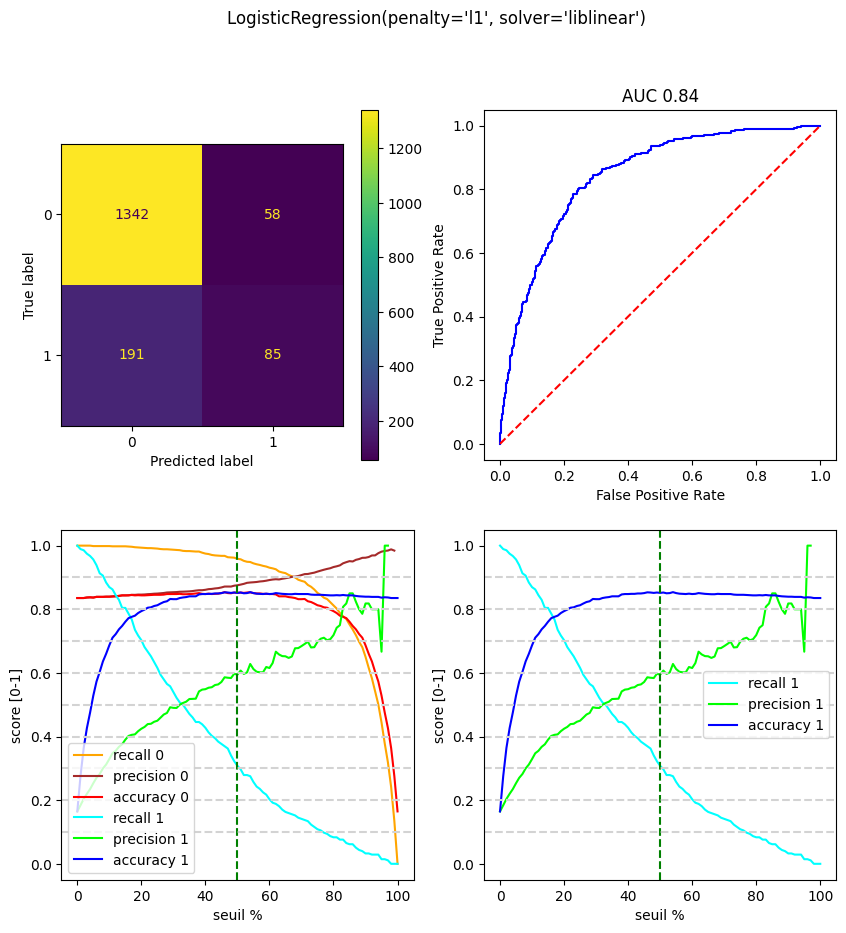

In [14]:
log_reg: LogisticRegression = LogisticRegression(
    solver="liblinear",
    penalty="l1"
)

log_reg.fit(X_scaled_train, y_train)
log_reg.score(X_scaled_train, y_train)
log_reg.score(X_scaled_test, y_test)

feature_weight_match: DataFrame = DataFrame(log_reg.coef_.T, index=preprocessed_df_X.columns.tolist(), columns=['weight'])
feature_weight_match = feature_weight_match.loc[feature_weight_match['weight'] != 0].sort_values('weight', ascending=False)
display(
    Markdown(feature_weight_match.head(5).to_markdown()),
    Markdown(feature_weight_match.tail(5).to_markdown()),
)

plots(log_reg, X_scaled_test, y_test)

{np.float64(0.5986066452304395), np.float64(3.035326086956522)}
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      1400
           1       0.40      0.78      0.53       276

    accuracy                           0.77      1676
   macro avg       0.68      0.78      0.69      1676
weighted avg       0.86      0.77      0.80      1676



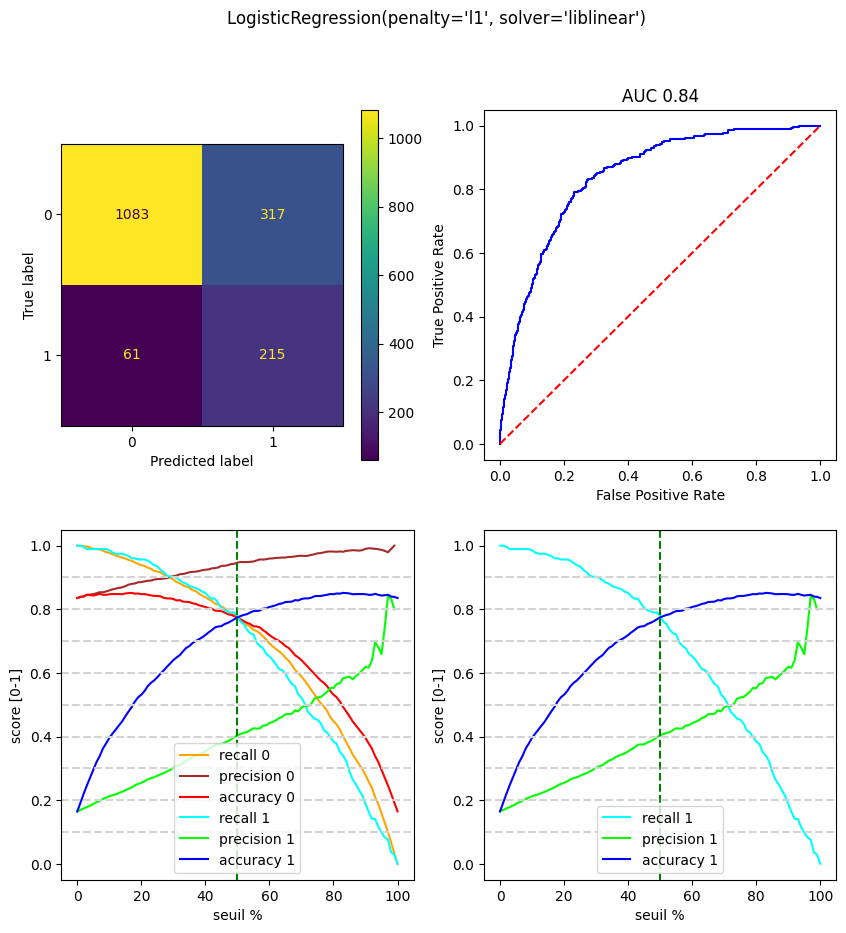

In [15]:
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np

# Calcul automatique
sample_weights = compute_sample_weight(
    'balanced',
    y=y_train
)

print(set(sample_weights))

log_reg: LogisticRegression = LogisticRegression(
    solver="liblinear",
    penalty="l1"
)

log_reg.fit(X_scaled_train, y_train, sample_weight=sample_weights)
log_reg.score(X_scaled_train, y_train)
log_reg.score(X_scaled_test, y_test)

feature_weight_match: DataFrame = DataFrame(log_reg.coef_.T, index=preprocessed_df_X.columns.tolist(), columns=['weight'])
feature_weight_match = feature_weight_match.loc[feature_weight_match['weight'] != 0].sort_values('weight', ascending=False)
# display(
#     Markdown(feature_weight_match.to_markdown()),
#     Markdown(feature_weight_match.tail(5).to_markdown())
# )

plots(log_reg, X_scaled_test, y_test)